In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append("/home/hossay/gaitanalysis")

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3,4"  # specify which GPU(s) to be used

In [4]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from train import LightningVideoClassifier
import json
import argparse
import math
import numpy as np
import random
from pytorch_lightning.callbacks import LearningRateLogger

In [5]:
def set_seed(seed):
    """
    For seed to some modules.
    :param seed: int. The seed.
    :return:
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [6]:
torch.backends.cudnn.benchmark = True
# for reproductivity
set_seed(0)

In [7]:
CONFIG_FILE = "../cfg/DefaultAGNet_UCF101@r2plus1d_18_cv.cfg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
with open(CONFIG_FILE) as file:
    # load hparams
    hparams = json.load(file)
hparams = argparse.Namespace(**hparams)

model = LightningVideoClassifier(hparams)
model.prepare_data()  # load datasets


train : 9537, test : 6765


In [9]:
# init logger
base_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs", name=f"{hparams.model_arch}_{hparams.backbone}"
)
lr_logger = LearningRateLogger()

trainer = pl.Trainer(
    gpus=2,
    distributed_backend="dp",
    logger=base_logger,
    log_save_interval=10,
    max_epochs=100,
    num_sanity_val_steps=0
)

model.trainer = trainer

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0,1]



train : 9537, test : 6765



    | Name                                                                | Type                 | Params
---------------------------------------------------------------------------------------------------------
0   | model                                                               | DefaultAGNet         | 121 M 
1   | model.guider                                                        | GuideNet             | 121 M 
2   | model.guider.guide_block                                            | GuideBlock           | 120 M 
3   | model.guider.guide_block.backbone                                   | Sequential           | 31 M  
4   | model.guider.guide_block.backbone.stem                              | R2Plus1dStem         | 15 K  
5   | model.guider.guide_block.backbone.stem.0                            | Conv3d               | 6 K   
6   | model.guider.guide_block.backbone.stem.1                            | BatchNorm3d          | 90    
7   | model.guider.guide_block.backbone.stem.

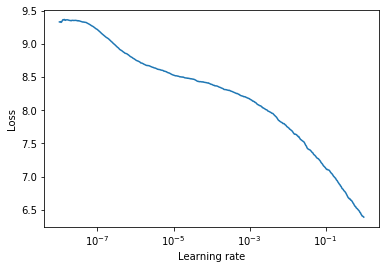

In [10]:
# Run lr finder
lr_finder = trainer.lr_find(model, num_training=len(model.train_dataloader())*2)

# Inspect results
fig = lr_finder.plot(); fig.show()

In [11]:
suggested_lr = lr_finder.suggestion()

In [12]:
suggested_lr

0.032013862719989454

In [13]:
import pandas as pd
import seaborn as sns

res = pd.DataFrame(lr_finder.results)
res[res["loss"] == res["loss"].min() ]

,lr,loss
561,1.0,6.389072
